# <center> Игровой интернем магазин "Стримчик"

### <center> Цель работы:
* Необходимо выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

### <center> Описание данных:
* Name — название игры
* Platform — платформа
* Year_of_Release — год выпуска
* Genre — жанр игры
* NA_sales — продажи в Северной Америке (миллионы проданных копий)
* EU_sales — продажи в Европе (миллионы проданных копий)
* JP_sales — продажи в Японии (миллионы проданных копий)
* Other_sales — продажи в других странах (миллионы проданных копий)
* Critic_Score — оценка критиков (максимум 100)
* User_Score — оценка пользователей (максимум 10)
* Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.


Данные за 2016 год могут быть неполными.


### Шаг 1. Открываем файл с данными, изучим общую информацию

In [1]:
# Импортируем библиотеки 
import pandas as pd
import seaborn as sns
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st
from scipy.stats import binom


In [2]:
# Загружаем данные
try:
    data = pd.read_csv('/datasets/games.csv')
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/games.csv')
display(data.head(10))
;

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


''

In [3]:
# Выводим информацию о загруженных данных и посчичтаем число явных дубликатов
data.info()
print()
print('Число явных дубликатов в таблице = ',data.duplicated().sum())
;

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB

Число явных дубликатов в таблице =  0


''

In [4]:
# неявных дубликатов строк, совпадающих по названию, платформе и году релиза
display(data.duplicated(subset=['Name', 'Platform','Year_of_Release']).value_counts())

False    16713
True         2
dtype: int64

In [5]:
# Количество значений в столбцах различается. Значит, в данных есть пропущенные значения.
missing = data.isna().sum()
percent_missing = data.isnull().sum() * 100 / len(data)
missing_value_data = pd.DataFrame({'missing': missing,
                                   'percent_missing %': round(percent_missing,2)})
display(missing_value_data)
;

,missing,percent_missing %
Name,2,0.01
Platform,0,0.00
Year_of_Release,269,1.61
Genre,2,0.01
NA_sales,0,0.00
EU_sales,0,0.00
JP_sales,0,0.00
Other_sales,0,0.00
Critic_Score,8578,51.32
User_Score,6701,40.09


''

Вывод:

Загрузили таблицу с данными,
- таблица "data" имеет 16715 строк, 11 столбцов, явных дубликатов не обнаружили.

Требуется преобразование типов данных в столбцах:
* Year_of_Release - год выхода, User_Score - нужно преобразовать в числовой формат

Первичный анализ пропусков в данных:
* 2 пропуска в столбце Name, 
* в столбце Year_of_Release имеются пропуски, данные скорее всего не заполнены либо утеряны
* 2 пропуска в столбце Genre, можно поискать жанр в других источниках
* пропуски в столбце Critic_Score и User_Score скорее всего связаны с тем что игру не оценивали либо она не была популярна, в столбце Rating пропуски связаны с отсутствием оценок, что не дает возможность оценить рейтинг, 
* также пропуски могут появляться по другим причинам, выясним при дальнейшем анализе


Данных достаточно для исследования.

### Шаг 2. Подготовим данные для анализа

In [6]:
# Выведим названия столбцов и преобразуем в нижний регистр
data.columns = data.columns.str.lower()
display(data.columns)
;

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

''

In [7]:
# Приведем к нижнему регистру столбцы с текстовыми данными:
for column in data[['name','platform','genre','rating']]:
    data[column] = data[column].str.lower()

In [8]:
# Рассмотрим пропуски в столбце с названием игр
display(data[data['name'].isnull()])
;

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,gen,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,gen,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


''

- Рассмотрим пропуски в столбцах name и genre это одни и те же игры, восстановить их не получится, 
- удалим эти данные, так как они не дают нам информацию для оценки и избавимся от пропусков сразу в вдвух столбцах

In [9]:
# Удалим строки с пропусками в столбах где процент пропусков меньше 5
data = data.dropna(subset=['name'])
data = data.dropna(subset=['year_of_release'])

# Количество значений в столбцах различается. Значит, в данных есть пропущенные значения.
missing = data.isna().sum()
percent_missing = data.isnull().sum() * 100 / len(data)
missing_value_data = pd.DataFrame({'missing': missing,
                                   'percent_missing %': round(percent_missing,2)})
display(missing_value_data)
;

,missing,percent_missing %
name,0,0.00
platform,0,0.00
year_of_release,0,0.00
genre,0,0.00
na_sales,0,0.00
eu_sales,0,0.00
jp_sales,0,0.00
other_sales,0,0.00
critic_score,8461,51.45
user_score,6605,40.17


''

**Пропуски в столбцах с оценками составляют половину данных, удалить или заполнить их мы не можем**

In [10]:
# заменим пропуски в столбце rating
data['rating'] = data['rating'].fillna('no data')
display(data.rating.value_counts())
;

no data    6676
e          3921
t          2905
m          1536
e10+       1393
ec            8
k-a           3
ao            1
rp            1
Name: rating, dtype: int64

''

- «EC» («Early childhood») — «Для детей младшего возраста»: Игра подходит для детей от 3 лет и не содержит материалов, которые родители могли бы счесть неподходящими. Продукты, получившие данный рейтинг, изначально разрабатываются для детей и обычно представляют собой развивающие игры.

- «E» («Everyone») — «Для всех»: Содержание вполне подходит для всех возрастов (ранее с 6 лет). Такие игры могут понравиться и взрослым. Игры с этим рейтингом могут содержать минимальное насилие, в основном «мультяшного» характера. Первоначально "K-A" ("Kids to Adults"):

- «E10+» («Everyone 10 and older») — «Для всех от 10 лет и старше»: Проекты с данным рейтингом могут содержать больше мультипликационного или мягкого насилия, или несколько откровенные сцены, или минимальное количество крови. Рейтинг был принят ESRB 2 марта 2005 года.

- «T» («Teen») — «Подросткам»: Игра подходит для лиц от 13 лет. Проекты из данной категории могут содержать насилие, непристойные сцены, грубый юмор, в меру откровенное сексуальное содержимое, кровь или нечастое использование ненормативной лексики.

- «M» («Mature») — «Для взрослых»: Материалы игры не подходят для лиц младше 17 лет. Проекты с данным рейтингом могут содержать жестокое насилие, большое количество крови с расчленением, непристойные сексуальные сцены или грубую ненормативную лексику.

- «AO» («Adults Only 18+») — «Только для взрослых»: Содержание игры только для взрослых старше 18 лет. Продукты из данной категории могут содержать длительные сцены жестокого насилия и/или очень откровенное сексуальное содержимое.

- «RP» («Rating Pending») — «Рейтинг ожидается»: Продукт был отправлен в ESRB и ожидает присвоения рейтинга. Данный логотип используется только на рекламных презентациях и в демо-версиях игр до официальной даты выпуска в продажу:

- «RP 17+» («Rating Pending») — «Рейтинг ожидается - примерно 17+»: Продукт отправлен ESRB на оценку, но примерное содержание близко к рейтингу «M». Данная маркировка была введена с 2021 г. и распространяется на демо или презентационный вариант

In [11]:
# заменим устаревшие оценки и оценки которые еще не выставлены
data.loc[data['rating'] == 'rp', 'rating'] = 'no data'
data.loc[data['rating'].isin(['k-a']), 'rating'] = 'e'
data.loc[data['rating'] == 'a0', 'rating'] = 'm'
display(data.rating.value_counts())
;

no data    6677
e          3924
t          2905
m          1536
e10+       1393
ec            8
ao            1
Name: rating, dtype: int64

''

In [12]:
# Рассмотрим пропуски в столбцах с оценками,
display(data[data['critic_score'].isnull()].head(10))
;

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
1,super mario bros.,nes,1985.0,platform,29.08,3.58,6.81,0.77,NaN,NaN,no data
4,pokemon red/pokemon blue,gb,1996.0,role-playing,11.27,8.89,10.22,1.00,NaN,NaN,no data
5,tetris,gb,1989.0,puzzle,23.20,2.26,4.22,0.58,NaN,NaN,no data
9,duck hunt,nes,1984.0,shooter,26.93,0.63,0.28,0.47,NaN,NaN,no data
10,nintendogs,ds,2005.0,simulation,9.05,10.95,1.93,2.74,NaN,NaN,no data
12,pokemon gold/pokemon silver,gb,1999.0,role-playing,9.00,6.18,7.20,0.71,NaN,NaN,no data
18,super mario world,snes,1990.0,platform,12.78,3.75,3.54,0.55,NaN,NaN,no data
20,pokemon diamond/pokemon pearl,ds,2006.0,role-playing,6.38,4.46,6.04,1.36,NaN,NaN,no data
21,super mario land,gb,1989.0,platform,10.83,2.71,4.18,0.42,NaN,NaN,no data
22,super mario bros. 3,nes,1988.0,platform,9.54,3.44,3.84,0.46,NaN,NaN,no data


''

In [13]:
# Заменим пропуски в столбце с оценкой критиков на -1
data['critic_score'] = data['critic_score'].fillna(-1)
# Преобразуем данные в столбце "оценка критиков" в правилльный тип
data['critic_score'] = data['critic_score'].astype('Int64')
display(data['critic_score'].unique())

<IntegerArray>
[76, -1, 82, 80, 89, 58, 87, 91, 61, 97, 95, 77, 88, 83, 94, 93, 85, 86, 98,
 96, 90, 84, 73, 74, 78, 92, 71, 72, 68, 62, 49, 67, 81, 66, 56, 79, 70, 59,
 64, 75, 60, 63, 69, 50, 25, 42, 44, 55, 48, 57, 29, 47, 65, 54, 20, 53, 37,
 38, 33, 52, 30, 32, 43, 45, 51, 40, 46, 39, 34, 41, 36, 31, 27, 35, 26, 19,
 28, 23, 24, 21, 17, 13]
Length: 82, dtype: Int64

In [14]:
# Преобразуем данные в столбце "год релиза" в правилльный тип
data['year_of_release'] = data['year_of_release'].astype('Int64', errors = 'ignore')
display(data['year_of_release'].unique())
;

<IntegerArray>
[2006, 1985, 2008, 2009, 1996, 1989, 1984, 2005, 1999, 2007, 2010, 2013, 2004,
 1990, 1988, 2002, 2001, 2011, 1998, 2015, 2012, 2014, 1992, 1997, 1993, 1994,
 1982, 2016, 2003, 1986, 2000, 1995, 1991, 1981, 1987, 1980, 1983]
Length: 37, dtype: Int64

''

 **В столбце user_scores встречается аббревиатура tbd**
 - To Be Determined, то есть "Будет определено". 
 - Стоит отметить также, что у этой аббревиатуры могут быть и иные значения, например To Be Done - должно быть сделано, или To Be Discussed - подлежит обсуждению: 
 
 То есть, данные были еще не заполнены, так как не определились с рейтингом. Поэтому предлагаю заменить tbd на Nan


In [15]:
# Преобразуем tbd  в np.nan
data['user_score'] = data['user_score'].replace('tbd', np.nan, regex=True)
# Заменим пропуски в столбце с оценкой пользователей на -1
data['user_score'] = data['user_score'].fillna(-1)
# Преобразуем данные в столбце с оценка пользователей в правилльный тип
data['user_score'] = data['user_score'].astype('float64', errors = 'ignore')
display(data['user_score'].unique())
;

array([ 8. , -1. ,  8.3,  8.5,  6.6,  8.4,  8.6,  7.7,  6.3,  7.4,  8.2,
        9. ,  7.9,  8.1,  8.7,  7.1,  3.4,  5.3,  4.8,  3.2,  8.9,  6.4,
        7.8,  7.5,  2.6,  7.2,  9.2,  7. ,  7.3,  4.3,  7.6,  5.7,  5. ,
        9.1,  6.5,  8.8,  6.9,  9.4,  6.8,  6.1,  6.7,  5.4,  4. ,  4.9,
        4.5,  9.3,  6.2,  4.2,  6. ,  3.7,  4.1,  5.8,  5.6,  5.5,  4.4,
        4.6,  5.9,  3.9,  3.1,  2.9,  5.2,  3.3,  4.7,  5.1,  3.5,  2.5,
        1.9,  3. ,  2.7,  2.2,  2. ,  9.5,  2.1,  3.6,  2.8,  1.8,  3.8,
        0. ,  1.6,  9.6,  2.4,  1.7,  1.1,  0.3,  1.5,  0.7,  1.2,  2.3,
        0.5,  1.3,  0.2,  0.6,  1.4,  0.9,  1. ,  9.7])

''

In [16]:
# Посчитаем суммарные продажи по всем регионам
data['total_sales'] = data['na_sales'] + data['eu_sales'] + data['jp_sales'] + data['other_sales']
display(data.info())
;

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  Int64  
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     16444 non-null  Int64  
 9   user_score       16444 non-null  float64
 10  rating           16444 non-null  object 
 11  total_sales      16444 non-null  float64
dtypes: Int64(2), float64(6), object(4)
memory usage: 1.7+ MB


None

''

**Вывод по подготовке данных:**

- Привели к правильному типу данные в столбце : year of release, critic_score, user_score
- Преобразовали к нижнему регистру данные в столбцах с текстовыми данными, а так же сами названия колонок
- Удалили пропуски в столбцах где они составляют менее 5% от данных, также обработали пропуски в значениях остальных столбцах
- Посчитали суммарные продажи во всех регионах и записали их в отдельный столбец total_sales


### Шаг 3. Проведем исследовательский анализ данных

- Посмотрите, сколько игр выпускалось в разные годы. Важны ли данные за все периоды?
- Посмотрите, как менялись продажи по платформам. Выберите платформы с наибольшими суммарными продажами и постройте распределение по годам. За какой характерный срок появляются новые и исчезают старые платформы?
- Возьмите данные за соответствующий актуальный период. Актуальный период определите самостоятельно в результате исследования предыдущих вопросов. Основной фактор — эти данные помогут построить прогноз на 2017 год.
- Не учитывайте в работе данные за предыдущие годы.
- Какие платформы лидируют по продажам, растут или падают? Выберите несколько потенциально прибыльных платформ.
- Постройте график «ящик с усами» по глобальным продажам игр в разбивке по платформам. Опишите результат.
- Посмотрите, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Постройте диаграмму рассеяния и посчитайте корреляцию между отзывами и продажами. Сформулируйте выводы.
- Соотнесите выводы с продажами игр на других платформах.
- Посмотрите на общее распределение игр по жанрам. Что можно сказать о самых прибыльных жанрах? Выделяются ли жанры с высокими и низкими продажами?

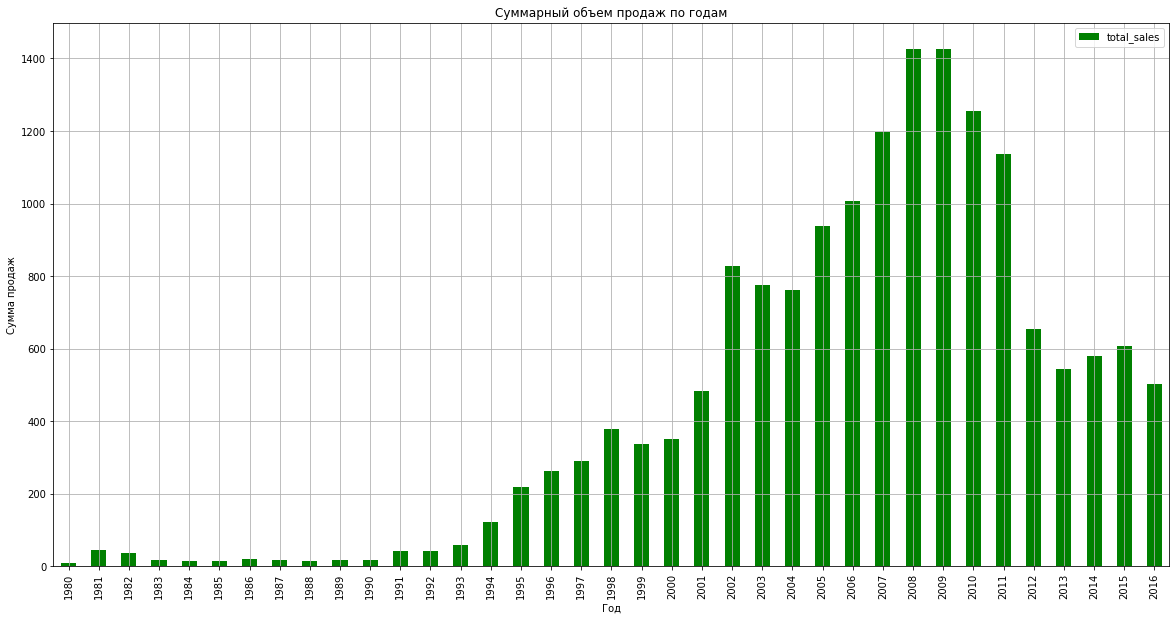

,total_sales
year_of_release,
2008,1427
2009,1426
2010,1255
2007,1197
2011,1136
2006,1006
2005,939
2002,829
2003,775


''

In [17]:
(
    data.pivot_table(index='year_of_release', values='total_sales', aggfunc='count')
    .plot(kind = 'bar', grid = True, figsize = (20,10), color = 'green')
)
plt.title('Суммарный объем продаж по годам')
plt.xlabel('Год')
plt.ylabel('Сумма продаж')
plt.axvline(x=2008, color = 'red')
plt.show()
display(data.pivot_table(index='year_of_release', values='total_sales', aggfunc='count')
        .sort_values('total_sales',ascending = False))
;

**Вывод:**
- Наибольшее число продаж зафиксировано в 2008 и 2009 годах, далее по убывающей
- Наименьшие продажи с 80 по 90 годы, связано с маленьким рынком так как было мало платформ и компьютер или консоль были недоступны для обычных людей, 
- Дальше спрос и предложение в игровом рынке значительно вырастают в связи с уменьшением порога входа в игровую индустрию, видим пик в двухтысячных,
- Спрос падает после 2010, рынок компьюткров выходит на пик, число платформ становится меньше 

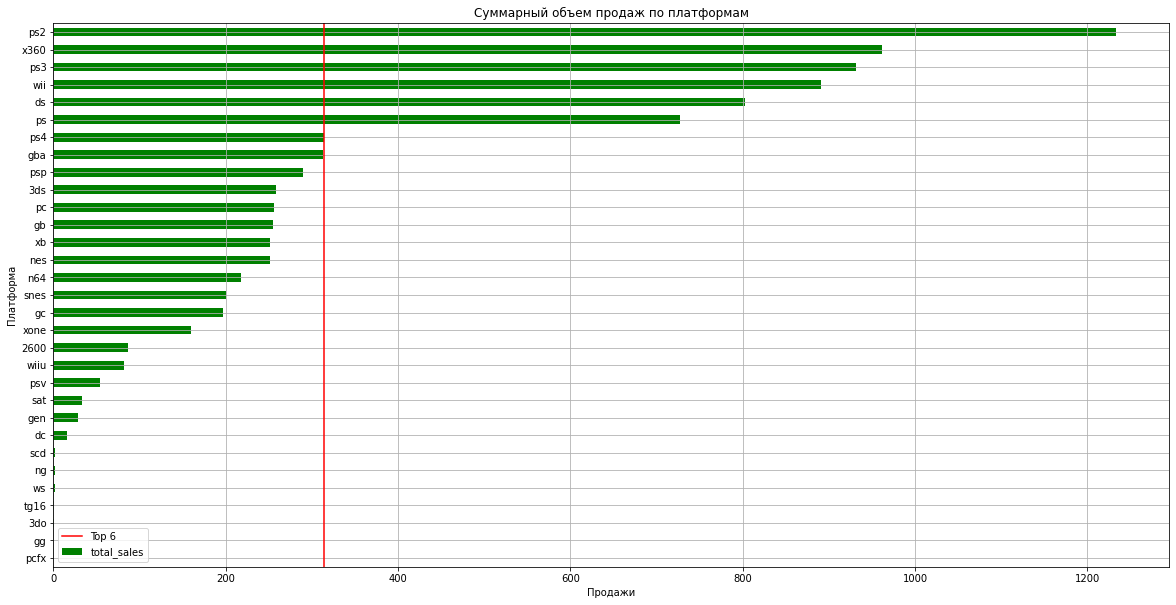

,total_sales
platform,
ps2,1233.56
x360,961.24
ps3,931.34
wii,891.18
ds,802.78
ps,727.58
ps4,314.14
gba,312.88
psp,289.53


''

In [18]:
(
    data.pivot_table(index='platform', values='total_sales', aggfunc='sum')
                    .sort_values('total_sales').plot(kind = 'barh', grid = True,figsize = (20,10), color = 'green')
)
plt.title('Суммарный объем продаж по платформам')
plt.xlabel('Продажи')
plt.ylabel('Платформа')
plt.axvline(x=314, color = 'red', label = 'Top 6')
plt.legend() 
plt.show()
display(data.pivot_table(index='platform', values='total_sales', aggfunc='sum')
        .sort_values('total_sales',ascending = False))
;

**Вывод**
- самые большие продажи зафиксированы на платформе ps2 и ds,
- возмем 6 самых популярных платформ и построим распределения по годам для каждой платформы

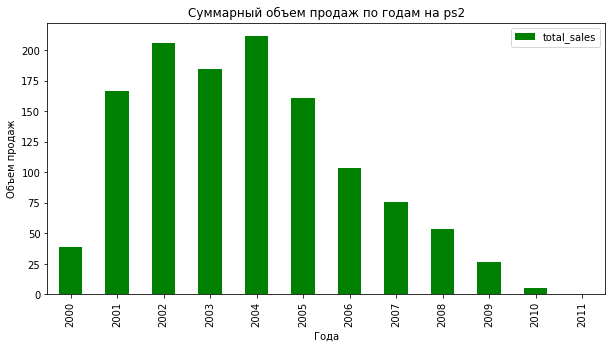

,total_sales
year_of_release,
2004,211.81
2002,205.38
2003,184.31
2001,166.43
2005,160.66
2006,103.42
2007,75.99
2008,53.90
2000,39.17


''

In [19]:
(
    data.query('platform == "ps2"')
     .pivot_table(index='year_of_release', values='total_sales', aggfunc='sum')
     .plot(kind='bar', figsize = (10,5), color ='green')
)
plt.title('Суммарный объем продаж по годам на ps2')
plt.xlabel('Года')
plt.ylabel('Объем продаж')
plt.show()
display(data.query('platform == "ps2"')
     .pivot_table(index='year_of_release', values='total_sales', aggfunc='sum')
        .sort_values('total_sales',ascending = False)
       )
;

- Наибольшее число продаж на платформе ps2, зафиксировано с 2001 по 2005 года, далее платформа устарела, соответственно спрос и производство игр упало
- платформа была актуальна 5 лет

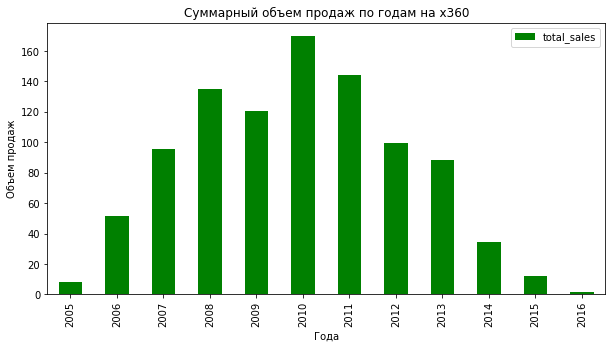

,total_sales
year_of_release,
2010,170.03
2011,143.84
2008,135.26
2009,120.29
2012,99.74
2007,95.41
2013,88.58
2006,51.62
2014,34.74


''

In [20]:
(
    data.query('platform == "x360"')
     .pivot_table(index='year_of_release', values='total_sales', aggfunc='sum')
     .plot(kind='bar', figsize = (10,5), color ='green')
)
plt.title('Суммарный объем продаж по годам на x360')
plt.xlabel('Года')
plt.ylabel('Объем продаж')
plt.show()
display(data.query('platform == "x360"')
     .pivot_table(index='year_of_release', values='total_sales', aggfunc='sum')
        .sort_values('total_sales',ascending = False)
       )
;

- Наибольшее число продаж на платформе x360, зафиксировано с 2008 по 2011 года, далее платформа устарела, соответственно спрос и производство игр упало
- платформа была актуальна 4 лет

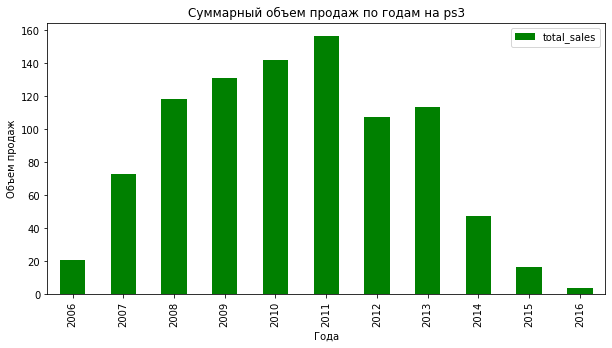

,total_sales
year_of_release,
2011,156.78
2010,142.17
2009,130.93
2008,118.52
2013,113.25
2012,107.36
2007,73.19
2014,47.76
2006,20.96


''

In [21]:
(
    data.query('platform == "ps3"')
     .pivot_table(index='year_of_release', values='total_sales', aggfunc='sum')
     .plot(kind='bar', figsize = (10,5), color ='green')
)
plt.title('Суммарный объем продаж по годам на ps3')
plt.xlabel('Года')
plt.ylabel('Объем продаж')
plt.show()
display(data.query('platform == "ps3"')
     .pivot_table(index='year_of_release', values='total_sales', aggfunc='sum')
        .sort_values('total_sales',ascending = False)
       )
;

- Наибольшее число продаж на платформе ps3, зафиксировано с 2008 по 2013 года, при этом в 2013 году видно всплеск продаж, возможно это связано с выходом какой-либо игры, далее платформа устарела, соответственно спрос и производство игр упало
- платформа была актуальна 6 лет

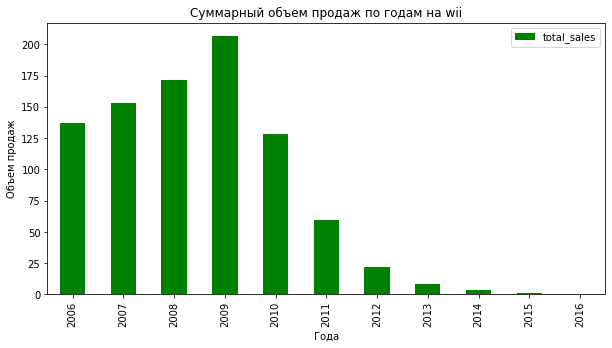

,total_sales
year_of_release,
2009,206.97
2008,171.32
2007,152.77
2006,137.15
2010,127.95
2011,59.65
2012,21.71
2013,8.59
2014,3.75


''

In [22]:
(
    data.query('platform == "wii"')
     .pivot_table(index='year_of_release', values='total_sales', aggfunc='sum')
     .plot(kind='bar', figsize = (10,5), color ='green')
)
plt.title('Суммарный объем продаж по годам на wii')
plt.xlabel('Года')
plt.ylabel('Объем продаж')
plt.show()
display(data.query('platform == "wii"')
     .pivot_table(index='year_of_release', values='total_sales', aggfunc='sum')
        .sort_values('total_sales',ascending = False)
       )
;

- Наибольшее число продаж на платформе wii, зафиксировано с 2006 по 2010 года, далее платформа устарела, соответственно спрос и производство игр упало
- платформа была актуальна 5 лет

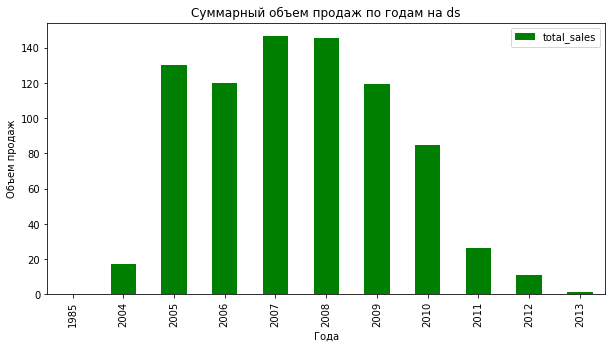

,total_sales
year_of_release,
2007,146.94
2008,145.31
2005,130.14
2006,119.81
2009,119.54
2010,85.02
2011,26.18
2004,17.27
2012,11.01


''

In [23]:
(
    data.query('platform == "ds"')
     .pivot_table(index='year_of_release', values='total_sales', aggfunc='sum')
     .plot(kind='bar', figsize = (10,5), color ='green')
)
plt.title('Суммарный объем продаж по годам на ds')
plt.xlabel('Года')
plt.ylabel('Объем продаж')
plt.show()
display(data.query('platform == "ds"')
     .pivot_table(index='year_of_release', values='total_sales', aggfunc='sum')
        .sort_values('total_sales',ascending = False)
       )
;

In [24]:
display(data.query('year_of_release == 1985' ))
;

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
1,super mario bros.,nes,1985,platform,29.08,3.58,6.81,0.77,-1,-1.0,no data,40.24
374,kung fu,nes,1985,action,1.64,0.38,1.42,0.06,-1,-1.0,no data,3.50
869,soccer,nes,1985,sports,0.18,0.23,1.53,0.02,-1,-1.0,no data,1.96
1262,ice climber,nes,1985,platform,0.46,0.10,0.92,0.02,-1,-1.0,no data,1.50
1482,gyromite,nes,1985,puzzle,0.73,0.16,0.40,0.03,-1,-1.0,no data,1.32
1971,tag team match m.u.s.c.l.e.,nes,1985,fighting,0.00,0.00,1.05,0.00,-1,-1.0,no data,1.05
2011,bomberman,nes,1985,puzzle,0.18,0.00,0.85,0.00,-1,-1.0,no data,1.03
2062,1942,nes,1985,shooter,0.65,0.14,0.21,0.00,-1,-1.0,no data,1.00
2252,balloon fight,nes,1985,platform,0.39,0.09,0.43,0.01,-1,-1.0,no data,0.92
3904,wrecking crew,nes,1985,platform,0.00,0.00,0.51,0.00,-1,-1.0,no data,0.51


''

- Найдена ошибка, платформа DS(Nintendo DS) не существовала в 1985г., она произведена в 2004 году
- strongest tokyo university shogi ds была выпущена в 2005 году, необходимо исправить в таблице

In [25]:
data.loc[15957, 'year_of_release'] = 2005
display(data.query('year_of_release == 1985' ))
;

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
1,super mario bros.,nes,1985,platform,29.08,3.58,6.81,0.77,-1,-1.0,no data,40.24
374,kung fu,nes,1985,action,1.64,0.38,1.42,0.06,-1,-1.0,no data,3.50
869,soccer,nes,1985,sports,0.18,0.23,1.53,0.02,-1,-1.0,no data,1.96
1262,ice climber,nes,1985,platform,0.46,0.10,0.92,0.02,-1,-1.0,no data,1.50
1482,gyromite,nes,1985,puzzle,0.73,0.16,0.40,0.03,-1,-1.0,no data,1.32
1971,tag team match m.u.s.c.l.e.,nes,1985,fighting,0.00,0.00,1.05,0.00,-1,-1.0,no data,1.05
2011,bomberman,nes,1985,puzzle,0.18,0.00,0.85,0.00,-1,-1.0,no data,1.03
2062,1942,nes,1985,shooter,0.65,0.14,0.21,0.00,-1,-1.0,no data,1.00
2252,balloon fight,nes,1985,platform,0.39,0.09,0.43,0.01,-1,-1.0,no data,0.92
3904,wrecking crew,nes,1985,platform,0.00,0.00,0.51,0.00,-1,-1.0,no data,0.51


''

- Наибольшее число продаж на платформе ds, зафиксировано с 2005 по 2010 года, далее платформа устарела, соответственно спрос и производство игр упало
- платформа была актуальна 6 лет

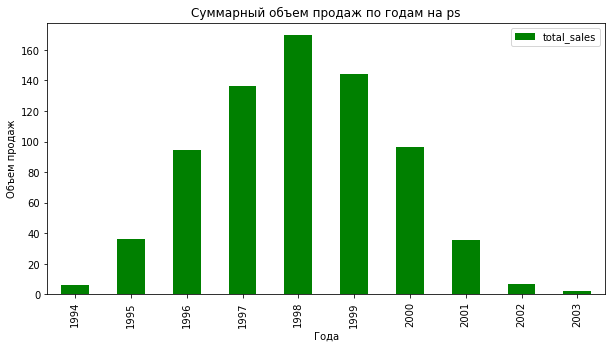

,total_sales
year_of_release,
1998,169.49
1999,144.53
1997,136.17
2000,96.37
1996,94.70
1995,35.96
2001,35.59
2002,6.67
1994,6.03


''

In [26]:
(
    data.query('platform == "ps"')
     .pivot_table(index='year_of_release', values='total_sales', aggfunc='sum')
     .plot(kind='bar', figsize = (10,5), color ='green')
)
plt.title('Суммарный объем продаж по годам на ps')
plt.xlabel('Года')
plt.ylabel('Объем продаж')
plt.show()
display(data.query('platform == "ps"')
     .pivot_table(index='year_of_release', values='total_sales', aggfunc='sum')
        .sort_values('total_sales',ascending = False)
       )
;

- Наибольшее число продаж на платформе ps, зафиксировано с 1996 по 2000 года, далее платформа устарела, соответственно спрос и производство игр упало
- платформа была актуальна 5 лет

In [27]:
# Для того чтобы определить время жизни платформы создадим таблицу
sales_platform = data[data['year_of_release'] != -1].pivot_table(index='year_of_release', columns='platform', values='total_sales', aggfunc='sum')
display(sales_platform)
;

platform,2600,3do,3ds,dc,ds,gb,gba,gc,gen,gg,...,sat,scd,snes,tg16,wii,wiiu,ws,x360,xb,xone
year_of_release,,,,,,,,,,,,,,,,,,,,,
1980,11.38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1981,35.68,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1982,28.88,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1983,5.84,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1984,0.27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1985,0.45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1986,0.67,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1987,1.94,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1988,0.74,NaN,NaN,NaN,NaN,1.43,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


''

In [28]:
# Расчет времени жизни платформы
platform_life=[]
for platform in sales_platform.columns:
    list = (sales_platform.index[~sales_platform[platform].isnull()])
    l = list.max()-list.min()+1
    platform_life.append(l)
display(np.mean(platform_life))
;

8.0

''

**Вывод**
- Новые платформы быстро набирают популярность в течении года или двух, удерживают ее в течение 4-5 лет а затем продажи снижаются. 
- Из нашего списка все платформы уже устарели.
- Время жизни платформы составляет 8 лет

**Актуальные данные**
- Актуальными данными примем информацию за предыдущие 3 года. 
- Следовательно, нам надо оставить 2016 год, 2015 год и 2014 год

In [29]:
actual_data = data.query('year_of_release >= 2014')
display(actual_data.head(10))

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
31,call of duty: black ops 3,ps4,2015,shooter,6.03,5.86,0.36,2.38,-1,-1.0,no data,14.63
42,grand theft auto v,ps4,2014,action,3.96,6.31,0.38,1.97,97,8.3,m,12.62
47,pokemon omega ruby/pokemon alpha sapphire,3ds,2014,role-playing,4.35,3.49,3.10,0.74,-1,-1.0,no data,11.68
77,fifa 16,ps4,2015,sports,1.12,6.12,0.06,1.28,82,4.3,e,8.58
87,star wars battlefront (2015),ps4,2015,shooter,2.99,3.49,0.22,1.28,-1,-1.0,no data,7.98
92,call of duty: advanced warfare,ps4,2014,shooter,2.81,3.48,0.14,1.23,83,5.7,m,7.66
94,fifa 17,ps4,2016,sports,0.66,5.75,0.08,1.11,85,5.0,e,7.60
96,super smash bros. for wii u and 3ds,3ds,2014,fighting,3.27,1.37,2.43,0.48,-1,-1.0,no data,7.55
99,call of duty: black ops 3,xone,2015,shooter,4.59,2.11,0.01,0.68,-1,-1.0,no data,7.39
105,fallout 4,ps4,2015,role-playing,2.53,3.27,0.24,1.13,87,6.5,m,7.17


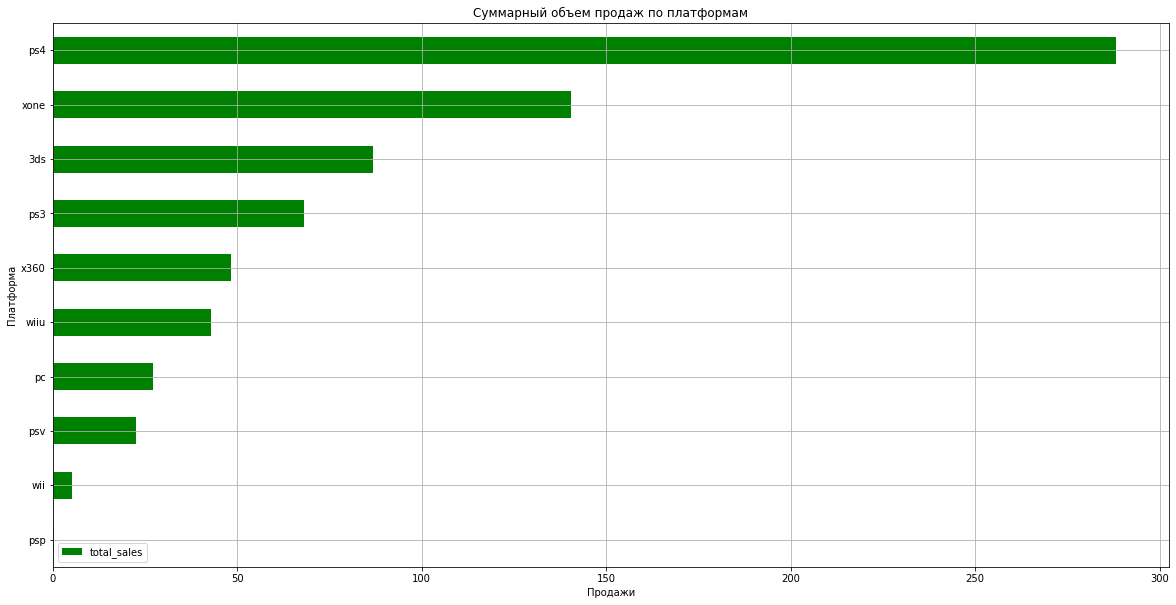

,total_sales
platform,
ps4,288.15
xone,140.36
3ds,86.68
ps3,68.18
x360,48.22
wiiu,42.98
pc,27.05
psv,22.40
wii,5.07


''

In [30]:
(
    actual_data.pivot_table(index='platform', values='total_sales', aggfunc='sum')
                    .sort_values('total_sales').plot(kind = 'barh', grid = True,figsize = (20,10), color = 'green')
)
plt.title('Суммарный объем продаж по платформам')
plt.xlabel('Продажи')
plt.ylabel('Платформа')
plt.show()
display(actual_data.pivot_table(index='platform', values='total_sales', aggfunc='sum')
        .sort_values('total_sales',ascending = False))
;

**Вывод**
- Платформы, с успешными показателями по продажам за 2014-2016 год, отличаются от платформ на графике за все время. 
- Если лидером по продажам была PS2, то сейчас PS4,
- Второе место по объему продаж игр за 2014-2016 год занимает Xbox One. 
- PS4 и Xbox One являются актуальными платформами которые предпочтительней  остальных

In [31]:
# Сохраним таблицу с актульными продажами
actual_data_sale = actual_data.pivot_table(index='platform', values='total_sales', aggfunc='sum')
actual_data_sale.sort_values('total_sales',ascending = False)

,total_sales
platform,
ps4,288.15
xone,140.36
3ds,86.68
ps3,68.18
x360,48.22
wiiu,42.98
pc,27.05
psv,22.40
wii,5.07


3ds


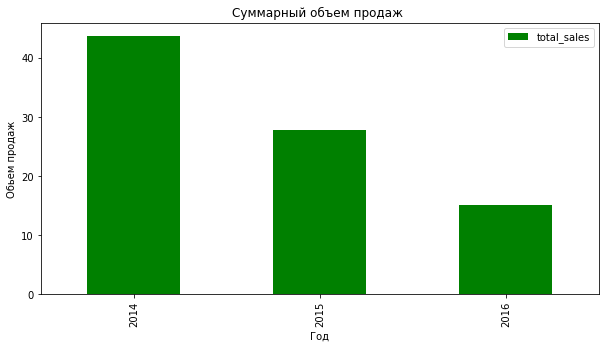

pc


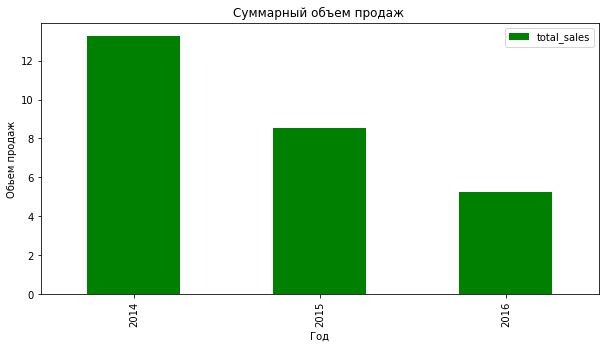

ps3


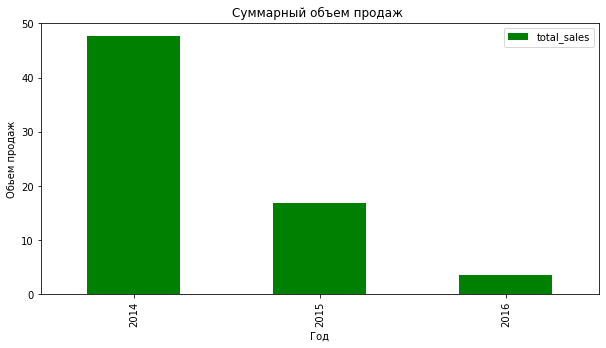

ps4


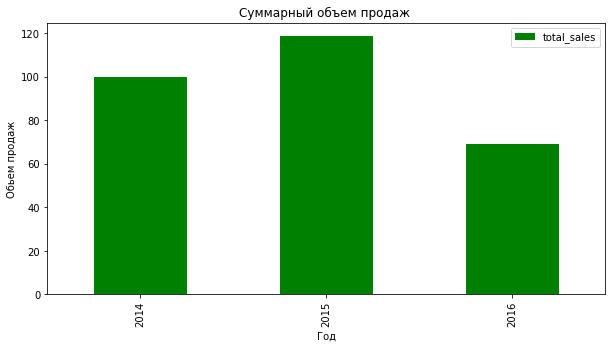

psp


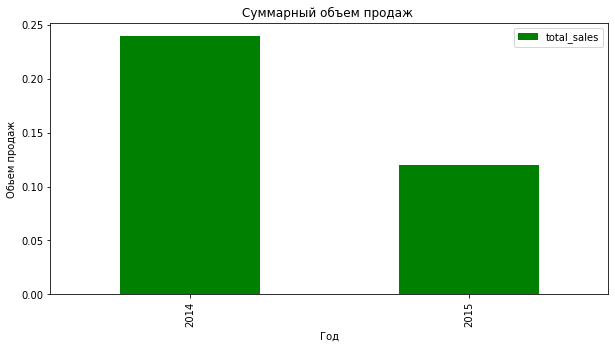

psv


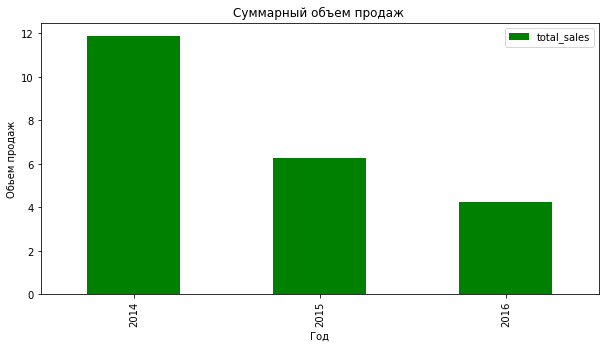

wii


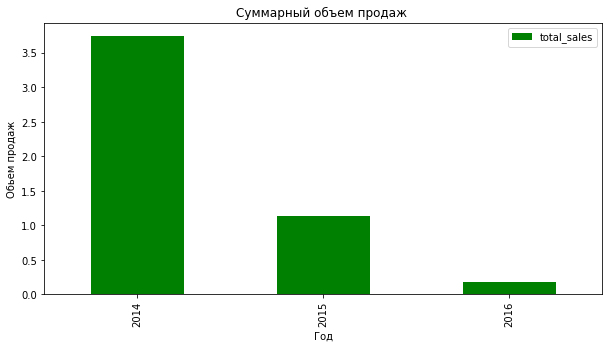

wiiu


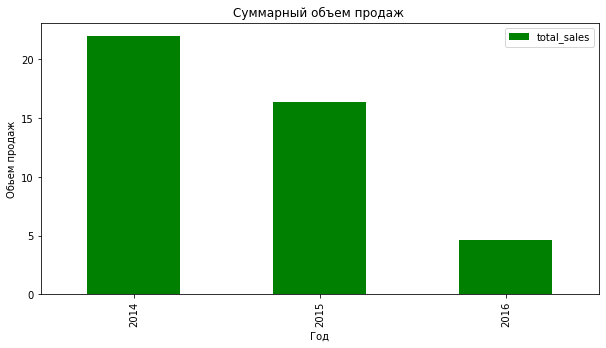

x360


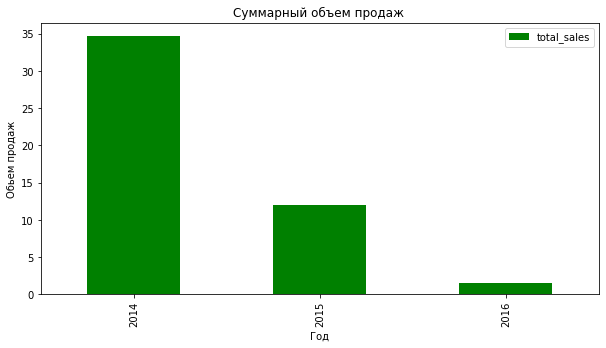

xone


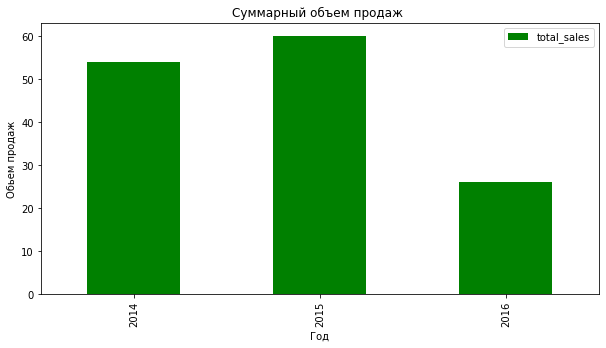

''

In [32]:
for platform in actual_data_sale.index:
    print(platform)
    (actual_data
     .query('platform == @platform')
     .pivot_table(index='year_of_release', values='total_sales', aggfunc='sum')
     .plot(kind='bar',figsize= (10,5), color = 'green')
    )
    plt.title('Суммарный объем продаж ')
    plt.xlabel('Год')
    plt.ylabel('Обьем продаж')
    plt.show()
;

 **Вывод**
 - По графикам видно что платформы указанные ниже на данный момент актуально но потеряют свою актуальность в ближайшие пару лет
 
- 3DS, 
- PS3, 
- X360,  
- PSP
- wii
- wiu

 Потенциально прибыльными считаем платформы на 2017
- PS4
- XOne
- wiiu
- wii
- PC

Не стоит забывать про рынок PC И PSV который стабильно имеет продажи, также портативный гейминг всегда актуален

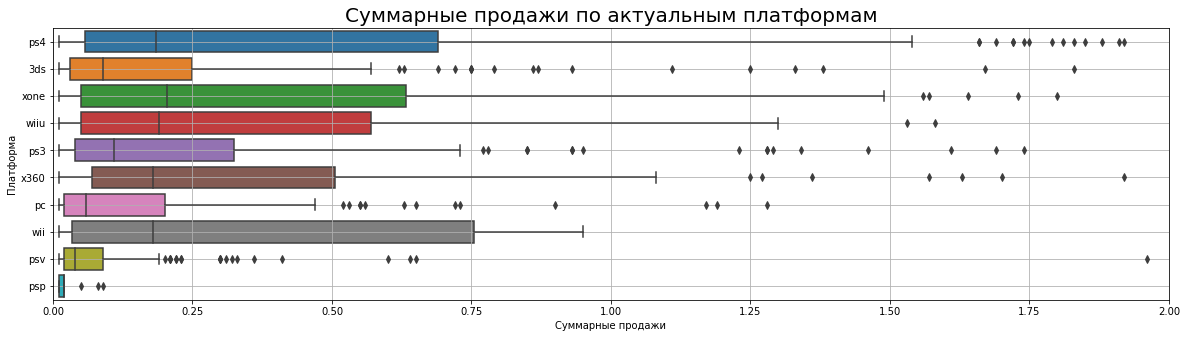

''

In [33]:
# Построим боксплоты по актуальным платформам
list_platforms = ['ps4', 'xone', 'psv', 'pc']
#data_platform = actual_data[actual_data['platform'].isin(list_platforms)]
data_platform = actual_data
plt.figure(figsize=(20, 5))
plt.xlim(0, 2)
plt.title('Суммарные продажи по актуальным платформам', fontsize=20)
sns.boxplot(x='total_sales', y='platform', data=data_platform, orient='h')
plt.ylabel('Платформа')
plt.xlabel('Суммарные продажи')
plt.grid(True)
plt.show()
;

- Медианное значение у лидеров находится дальше остальных. Разброс больше, больше число продаж

- Размах усов для ящиков ограничен минимуом и максимумом, и он шире чем у двух других консолей. 
- В диапазон боксплота попадает большое количество нормальных значений. 
- Платформы имеют большое число продаж. Выбросы и аномалии находятся за приделами усов.

In [34]:
#Посмотрим, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. 
data_ps4 = data_platform[(data_platform['platform'] == 'ps4') & (data_platform['user_score'] >0) ]
display(data_ps4.head(10))
;

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
42,grand theft auto v,ps4,2014,action,3.96,6.31,0.38,1.97,97,8.3,m,12.62
77,fifa 16,ps4,2015,sports,1.12,6.12,0.06,1.28,82,4.3,e,8.58
92,call of duty: advanced warfare,ps4,2014,shooter,2.81,3.48,0.14,1.23,83,5.7,m,7.66
94,fifa 17,ps4,2016,sports,0.66,5.75,0.08,1.11,85,5.0,e,7.60
105,fallout 4,ps4,2015,role-playing,2.53,3.27,0.24,1.13,87,6.5,m,7.17
143,fifa 15,ps4,2014,sports,0.80,4.33,0.05,0.90,82,5.7,e,6.08
154,destiny,ps4,2014,shooter,2.49,2.07,0.16,0.92,76,6.1,t,5.64
171,uncharted 4: a thief's end,ps4,2016,shooter,1.85,2.50,0.19,0.85,93,7.9,t,5.39
231,uncharted: the nathan drake collection,ps4,2015,action,2.07,1.71,0.08,0.76,86,8.1,t,4.62
245,call of duty: infinite warfare,ps4,2016,shooter,1.61,2.00,0.15,0.71,77,3.4,m,4.47


''

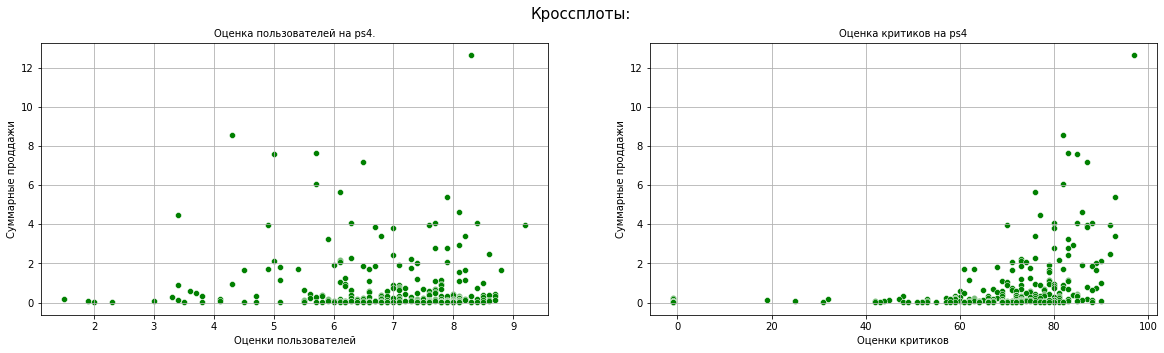

In [35]:
# Построим диаграмму рассеяния и посчитайте корреляцию между отзывами и продажами.
plt.figure(figsize=(20, 5))
plt.suptitle('Кроссплоты:', fontsize=15)

plt.subplot(1, 2, 1)
plt.title('Оценка пользователей на ps4.', fontsize=10)
sns.scatterplot(x='user_score', y='total_sales', data=data_ps4,color ='green')
plt.ylabel('Суммарные проддажи')
plt.xlabel('Оценки пользователей')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.title('Оценка критиков на ps4', fontsize=10)
sns.scatterplot(x='critic_score', y='total_sales', data=data_ps4,color ='green')
plt.ylabel('Суммарные проддажи')
plt.xlabel('Оценки критиков')
plt.grid(True);

In [36]:
corr_critic = data_ps4['total_sales'].corr(data_ps4['critic_score'].astype('float32'))
corr_user = data_ps4['total_sales'].corr(data_ps4['user_score'])
print(f'\nКоэффицент корреляции для отзывов критиков - {corr_critic:.2f}')
print(f'\nКоэффицент корреляции для отзывов пользователей - {corr_user:.2f}')


Коэффицент корреляции для отзывов критиков - 0.34

Коэффицент корреляции для отзывов пользователей - -0.04


**Отзывы критиков имеют некоторое влияние на продажи, но не значительное**

''

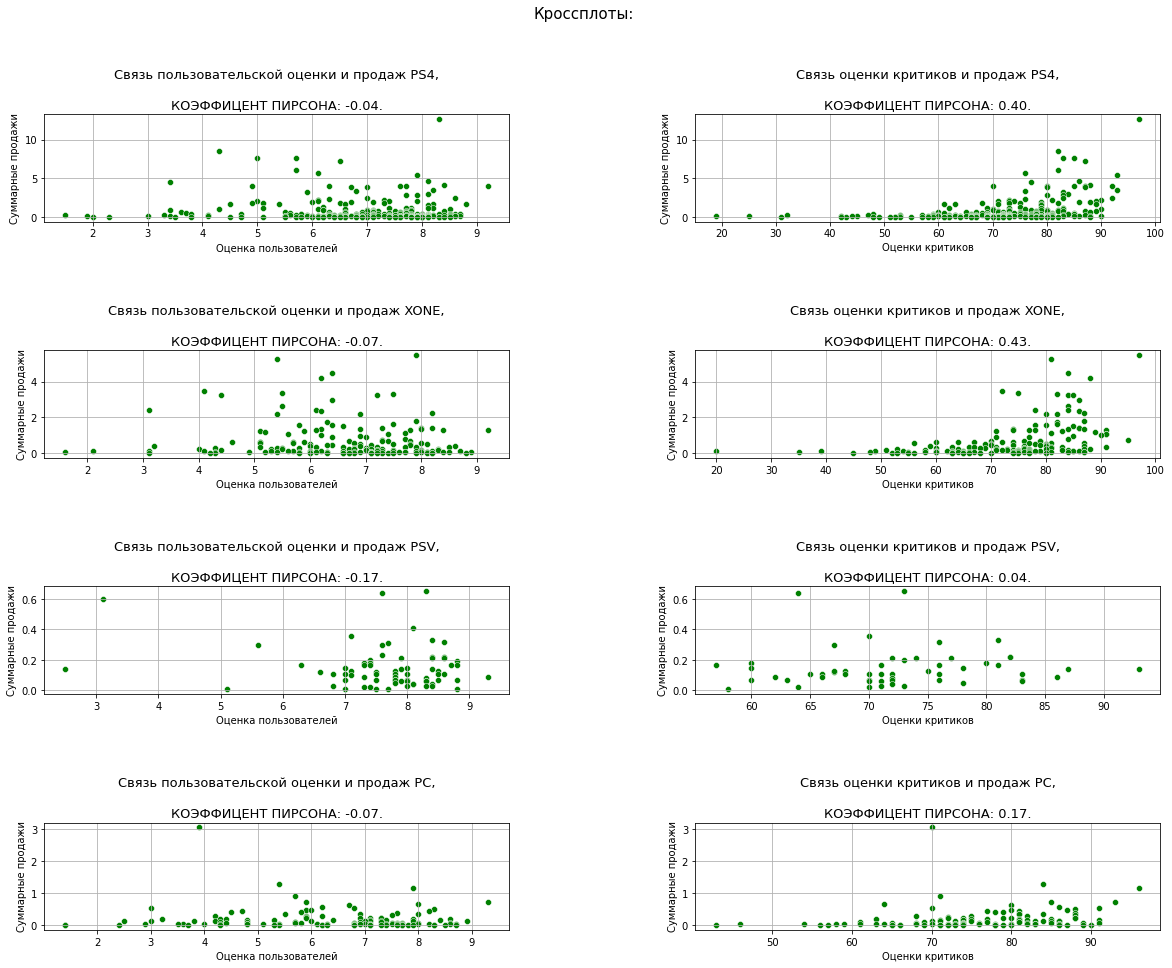

In [37]:
position = 0
plt.figure(figsize=[20,15])
plt.subplots_adjust(wspace=0.4, hspace=1.2)
plt.suptitle('Кроссплоты:', fontsize=15)

for name_of_platform in list_platforms:
    position += 1
    data_pl_us = data_platform[(data_platform['platform'] == name_of_platform) & (data_platform['user_score'] >0)]
    data_pl_cr = data_platform[(data_platform['platform'] == name_of_platform) & (data_platform['critic_score'] >0)]
    plt.subplot(4, 2, position)
    cor_with_user_score = data_pl_us['total_sales'].corr(data_pl_us['user_score'])
    plt.title(f'Связь пользовательской оценки и продаж {name_of_platform.upper()},\n\nКОЭФФИЦЕНТ ПИРСОНА: {cor_with_user_score:.2f}.', fontsize=13)
    sns.scatterplot(x='user_score', y='total_sales', data=data_pl_us,color = 'green')
    plt.xlabel('Оценка пользователей')
    plt.ylabel('Суммарные продажи')
    plt.grid(True)
    
    position += 1
    plt.subplot(4, 2, position)
    cor_with_critic_score = data_pl_cr['total_sales'].corr(data_pl_cr['critic_score'].astype('float32'))
    plt.title(f'Связь оценки критиков и продаж {name_of_platform.upper()},\n\nКОЭФФИЦЕНТ ПИРСОНА: {cor_with_critic_score:.2f}.', fontsize=13)
    sns.scatterplot(x='critic_score', y='total_sales', data=data_pl_cr,color = 'green')
    plt.xlabel('Оценки критиков')
    plt.ylabel('Суммарные продажи')
    plt.grid(True)
;
    

- Наибольшее влияние на продажи оказывают оценки критиков на плотформах  PS4, xbox one  и PC

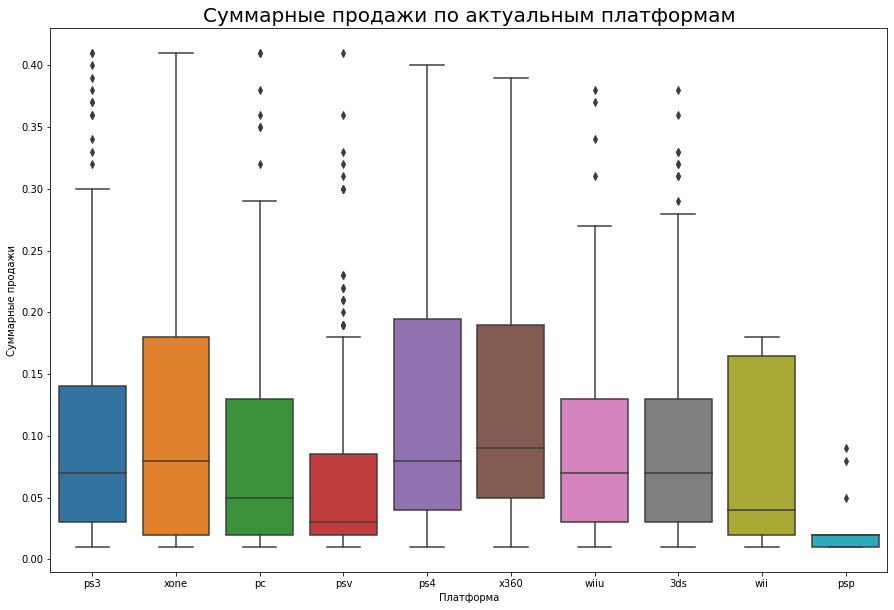

''

In [38]:
top = data_platform['total_sales'].quantile(0.75)
low = data_platform['total_sales'].quantile(0.25)
hold = top + 2*low
fig, ax = plt.subplots(figsize =(15,10))
sns.boxplot(x = 'platform', 
            y = 'total_sales',
            data = data_platform.query('total_sales <= @hold'),ax=ax)  
plt.title('Суммарные продажи по актуальным платформам', fontsize=20)
plt.xlabel('Платформа')
plt.ylabel('Суммарные продажи')  
plt.show()
;

- У платформ ps4, x360 , wii большая часть значений находятся выше 2 квартиля. 
- Наиболее равномерно распределены значения у платформы xone, wiiu, 3ds
- много аномальных значений на платформе psv
- больше всего игр на платформах ps4, x360 , wii и xone

''

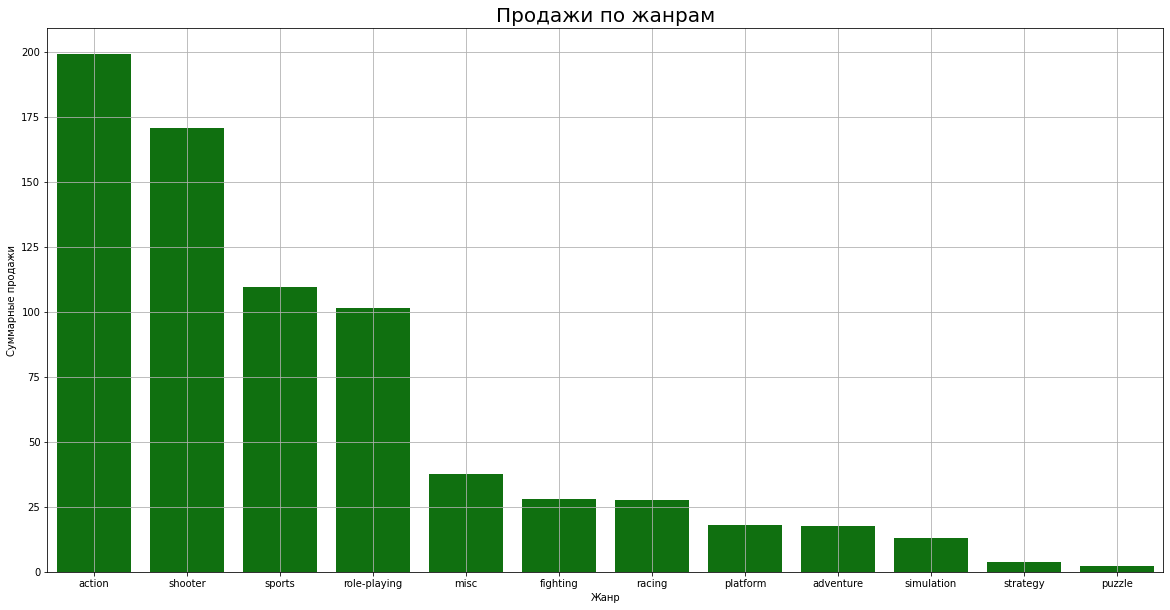

In [39]:
# Рассмотрим объем продаж по жанрам
all_genre = data_platform.pivot_table(index='genre', values='total_sales', aggfunc='sum').sort_values(by='total_sales', ascending=False).reset_index()
plt.figure(figsize=(20, 10))
plt.title('Продажи по жанрам', fontsize=20)
sns.barplot(x='genre', y='total_sales', data=all_genre,color = 'green')
plt.ylabel('Суммарные продажи')
plt.xlabel('Жанр')
plt.grid(True)
;

''

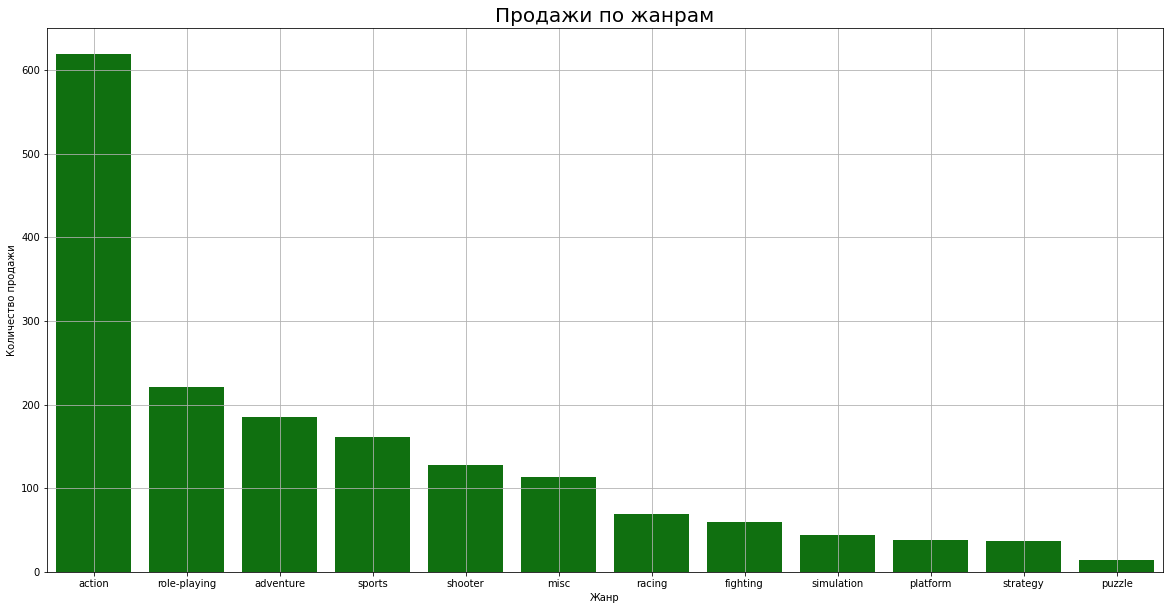

In [40]:
# Рассмотрим объем продаж по жанрам
all_genre = data_platform.pivot_table(index='genre', values='total_sales', aggfunc='count').sort_values(by='total_sales', ascending=False).reset_index()
plt.figure(figsize=(20, 10))
plt.title('Продажи по жанрам', fontsize=20)
sns.barplot(x='genre', y='total_sales', data=all_genre,color = 'green')
plt.ylabel('Количество продажи')
plt.xlabel('Жанр')
plt.grid(True)
;

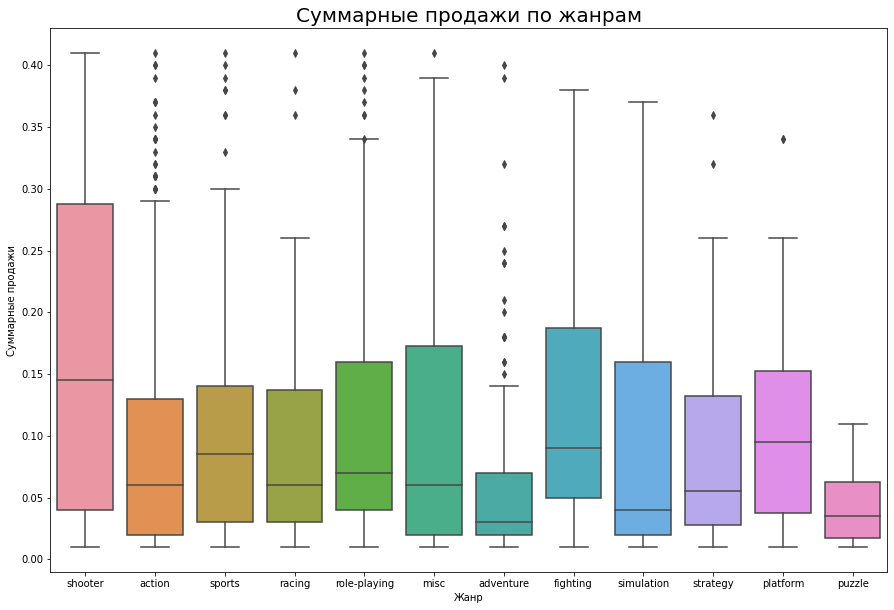

''

In [41]:
top = data_platform['total_sales'].quantile(0.75)
low = data_platform['total_sales'].quantile(0.25)
hold = top + 2*low
fig, ax = plt.subplots(figsize =(15,10))
sns.boxplot(x = 'genre', 
            y = 'total_sales',
            data = data_platform.query('total_sales <= @hold'),ax=ax)  
plt.title('Суммарные продажи по жанрам', fontsize=20)
plt.xlabel('Жанр')
plt.ylabel('Суммарные продажи') 
plt.show()
;


- Самый популярный жанр - "shooter", зоть у него и меньше продаж в пике но медианное значение самое высокое, а меньше всего у "adventure", этот жанр менее популярен.

- Топ популярных составляют жанры: "shooter","fighting","platform" "action", "sports", "role-playing". У них наибольшее количество продаж по медиане"


**Вывод**
- Самые прибыльные жанры являются шутеры и экшены. Значения их продаж доходят  до 200 млн. 
- можно выдеелить  следующие жанры: "shooter","fighting","platform" "action", "sports", "role-playing". 
 
**Эти жанры можно считать потенциально прибыльными на будущее**

### Шаг 4 Составим портрет пользователя каждого региона.
- Определим для пользователя каждого региона (NA, EU, JP) самые популярные платформы (топ-5).

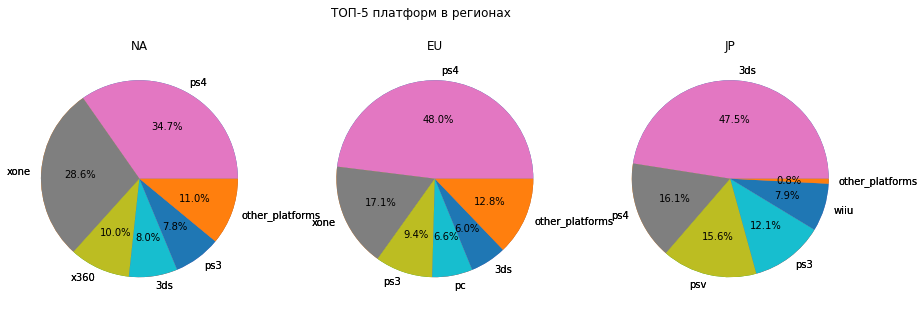

''

In [42]:
# список регионов
region = actual_data.columns[4:7]
# круговая диаграмма для каждого региона
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('ТОП-5 платформ в регионах')
for i in range(3):
  # 5 самых продающих платформ
  data_i = (actual_data.groupby('platform')[region[i]].sum().
             reset_index().
             sort_values(region[i], ascending = False, ignore_index = True).
             head(5))
  # занесем все остальыне продажи в Other_platforms
  data_i = data_i.append({'platform': 'other_platforms', region[i]: actual_data[region[i]].sum() - data_i[region[i]].sum()}, ignore_index= True)
  axs[i].pie(data_i[region[i]], labels = data_i['platform'])
  axs[i].pie(data_i[region[i]], labels = data_i['platform'], autopct='%1.1f%%')
  # Зададим название региона.
  axs[i].set_title(data_i.columns[1].split('_')[0].upper())
plt.show()
;

- В Северной Америке и Европе на первом месте стоит платформа PS4, а второе место занимает с небольшим отчтаванием XOne. 
- Япония имеет спецефичный рынок, здесь на первом месте стоит 3DS, второе место занимает PS4, и на третьем находится PSV.
- в целом картина по регионам схожа, но в Японии пользователи предпочитают игры и платформы немного другого типа

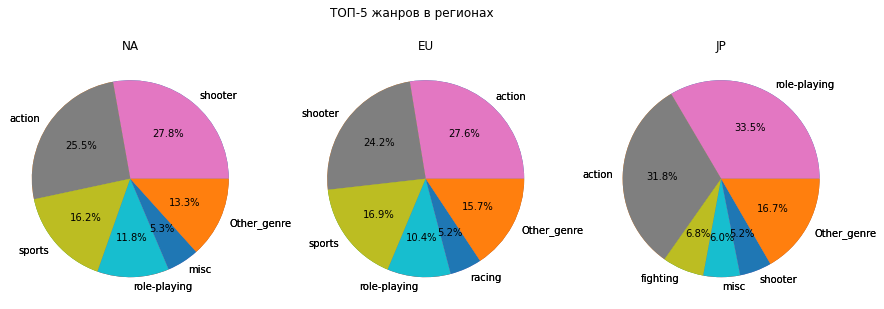

''

In [43]:
# круговая диаграмма для каждого региона
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('ТОП-5 жанров в регионах')
for i in range(3):
  # 5 самых продающих жанров
  data_i = (actual_data.groupby('genre')[region[i]].sum().
             reset_index().
             sort_values(region[i], ascending = False, ignore_index = True).
             head(5))
  # занесем все остальыне продажи в Other_genre
  data_i = data_i.append({'genre': 'Other_genre', region[i]: actual_data[region[i]].sum() - data_i[region[i]].sum()}, ignore_index= True)
  axs[i].pie(data_i[region[i]], labels = data_i['genre'])
  axs[i].pie(data_i[region[i]], labels = data_i['genre'], autopct='%1.1f%%')
  # Зададим название региона.
  axs[i].set_title(data_i.columns[1].split('_')[0].upper())
plt.show()
;

Для Северной Америки самыми популярными платформами являются:

- SHOOTER

- ACTION

- SPORTS

- ROLE-PLAYING


Для Европейского региона самыми популярными платформами являются:

- ACTION

- SHOOTER

- RACING

- SPORTS

- ROLE-PLAYING

Для Японии самыми популярными платформами являются:

- ROLE-PLAYING

- ACTION

- FIGHTING

- MISC

- SHOOTER

Разница в предпочтении жанров может быть обусловлена менталитетом и предпочтении определенных консолей.

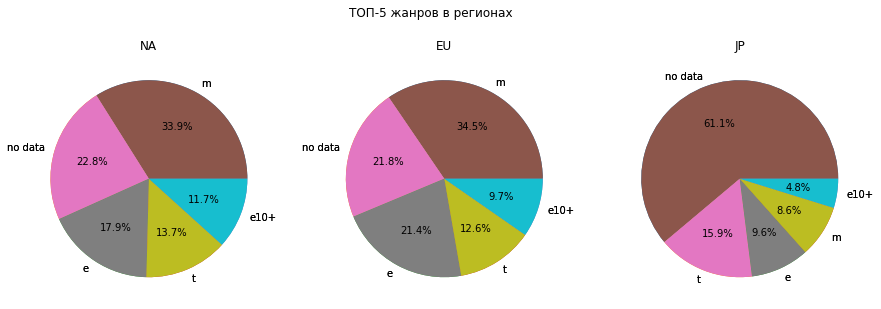

''

In [44]:
# круговая диаграмма для каждого региона
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('ТОП-5 жанров в регионах')
for i in range(3):
  # влияние рейтинга
  data_i = (actual_data.groupby('rating')[region[i]].sum().
             reset_index().
             sort_values(region[i], ascending = False, ignore_index = True).
             head(5))
  axs[i].pie(data_i[region[i]], labels = data_i['rating'])
  axs[i].pie(data_i[region[i]], labels = data_i['rating'], autopct='%1.1f%%')
  # Зададим название региона.
  axs[i].set_title(data_i.columns[1].split('_')[0].upper())
plt.show()
;

**Вывод**
- рейтинг ESRB влияет незначительно, 
- Исключение составляет Япония, в этом регионе, очень много игр без оценок. 
- Для Европы и Северной Америки можно выделить категорию М - для взрослых, она занимает большую часть рынка с

Портрет Американца
- Играет на PlayStation 4 
- Играет в шутеры, с рейтингом для взрослых


Портрет Европейца сопоставим с Американцем 

Портрет Японца
- Чаще всего играет на 3DS
- Лиграть в ролевые игры
- Любит специфичные игры редких жанров

Скорее всего это связано с цензурой которая не устраивает Японцев, которые любят специфичные игры. Также возможно у них есть свое агенство по оценке и свой рейтинг который не попал в нашу таблицу

### Шаг 5. Проверим гипотезы.

Сформулируем гипотезы:
- Н₀: Средние пользовательские рейтинги платформ Xbox One и PC равны  .

- H₁: Средние пользовательские рейтинги платформ Xbox One и PC различаются.

In [45]:
# удаление пустых значений
u_score = actual_data[actual_data['user_score'] != -1]

print('Средний пользовательский рейтинг платформ Xbox One', round(u_score.query('platform == "xone"')['user_score'].mean(),2))
print('Средний пользовательский рейтинг платформ PC', round(u_score.query('platform == "pc"')['user_score'].mean(),2))

results = st.ttest_ind(
    u_score.query('platform == "xone"')['user_score'], 
    u_score.query('platform == "pc"')['user_score'], 
    equal_var=False)

alpha = 0.05
print()
print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Средний пользовательский рейтинг платформ Xbox One 6.59
Средний пользовательский рейтинг платформ PC 6.3

p-значение: 0.11601398086668832
Не получилось отвергнуть нулевую гипотезу


**Вывод**
- Можем сделать вывод, что средние пользовательские рейтинги платформ Xbox One и PC отличаются не значительно

Сформулируем гипотезы:

- (H0): Средние пользовательские рейтинги жанров Action и Sports равны.
- (H1): Средние пользовательские рейтинги жанров Action и Sports не равны.

In [46]:
print('Средний пользовательский рейтинг жанра экшен', round(u_score.query('genre == "action"')['user_score'].mean(),2))
print('Средний пользовательский рейтинг жанра спортивных игр', round(u_score.query('genre == "sports"')['user_score'].mean(),2))


results = st.ttest_ind(
    u_score.query('genre == "action"')['user_score'], 
    u_score.query('genre == "sports"')['user_score'], 
    equal_var=False)

alpha = 0.05
print()
print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Средний пользовательский рейтинг жанра экшен 6.76
Средний пользовательский рейтинг жанра спортивных игр 5.23

p-значение: 1.1825550382644557e-14
Отвергаем нулевую гипотезу


**Вывод**
-  Можем сделать вывод, что средние пользовательские рейтинги жанров action и sports отличаются значительно

- Нулевая гипотеза (H₀) всегда формулируется по формулировке вопроса.
- Исходя из формулировки H₀ формулириуется альтернативная гипотеза (H₁). 
- Это утверждение, которое принимается верным, когда отбрасывается нулевая гипотеза.

Пороговое значение сделаю равное 5%, как общепринятое.

Логика проверки.

- Вычислить значение (p-value) критерия значимости. Если значение будет большим (сравним с пороговым значением), то нулевую гипотезу не отвергаем.

### Общий вывод

Загрузили таблицу с данными,
- таблица "data" имеет 16715 строк, 11 столбцов, явных дубликатов не обнаружили.

- Привели к правильному типу данные в столбце : year of release, critic_score, user_score
- Преобразовали к нижнему регистру данные в столбцах с текстовыми данными, а так же сами названия колонок
- Удалили пропуски в столбцах где они составляют менее 5% от данных, также обработали пропуски в значениях остальных столбцах
- Посчитали суммарные продажи во всех регионах и записали их в отдельный столбец total_sales

**Вывод**

- Наибольшее число продаж зафиксировано в 2008 и 2009 годах, далее по убывающей
- Наименьшие продажи с 80 по 90 годы, связано с маленьким рынком так как было мало платформ и компьютер или консоль были недоступны для обычных людей, 
- Дальше спрос и предложение в игровом рынке значительно вырастают в связи с уменьшением порога входа в игровую индустрию, видим пик в двухтысячных,
- Спрос падает после 2010, рынок компьюткров выходит на пик, число платформ становится меньше 
- Самые прибыльные жанры являются шутеры и экшены. Значения их продаж доходят  до 140 млн. 
- можно выдеелить  следующие жанры: "shooter","action", "sports", "role-playing"
- самые большие продажи зафиксированы на платформе ps2 и ds,
- Новые платформы быстро набирают популярность в течении года или двух, удерживают ее в течение 4-5 лет а затем продажи снижаются. 
- Из нашего списка все платформы уже устарели.
- Платформы, с успешными показателями по продажам за 2014-2016 год, отличаются от платформ на графике за все время.
- Если лидером по продажам была PS2, то сейчас PS4,
- Второе место по объему продаж игр за 2014-2016 год занимает Xbox One.
- PS4 и Xbox One являются актуальными платформами которые предпочтительней остальных

**Потенциально прибыльными считаем платформы на 2017**
- PS4
- XOne
- PSV
- PC

Не стоит забывать про рынок PC И PSV который стабильно имеет продажи, также портативный гейминг всегда актуален

- Самые прибыльные жанры являются шутеры и экшены. Значения их продаж доходят  до 140 млн. 
- можно выдеелить  следующие жанры: "shooter","action", "sports", "role-playing"
**Эти жанры можно считать потенциально прибыльными на будущее**

- рейтинг ESRB влияет незначительно, 
- Исключение составляет Япония, в этом регионе, очень много игр без оценок. 
- Для Европы и Северной Америки можно выделить категорию М - для взрослых, она занимает большую часть рынка с


Портрет Американца
- Играет на PlayStation 4 
- Играет в шутеры, с рейтингом для взрослых

Портрет Европейца сопоставим с Американцем 

Портрет Японца
- Чаще всего играет на 3DS
- Лиграть в ролевые игры
- Любит специфичные игры редких жанров

Сформулировали  и проверили гипотезы
- Н₀: Средние пользовательские рейтинги платформ Xbox One и PC равны .
- H₁: Средние пользовательские рейтинги платформ Xbox One и PC различаются.
 
 в данном случае не получилось отвергнуть нулевую гипотезу,


- (H0): Средние пользовательские рейтинги жанров Action и Sports равны.
- (H1): Средние пользовательские рейтинги жанров Action и Sports не равны. 
 
 в этом случае нулевая гипетиза была отвергнута